In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
# from lmfit import minimize, Parameters, report_fit

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Interpolation function for smooth Z
Z = np.nan_to_num(Z, nan=0.0)
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

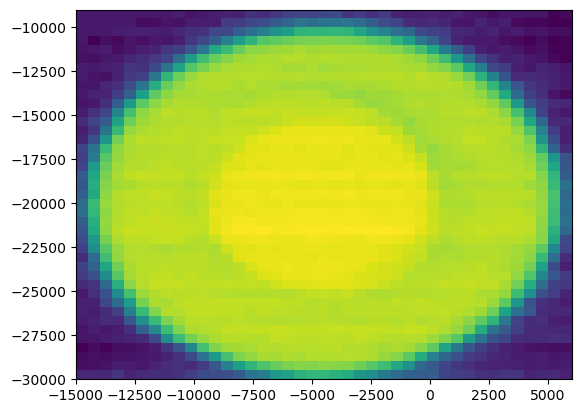

In [5]:
plotted_Z = Z_vals.reshape(xx.shape)
plt.imshow(plotted_Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', aspect='auto')

Optimization success: True
Fitted center: x = -4508.66, y = -18946.19


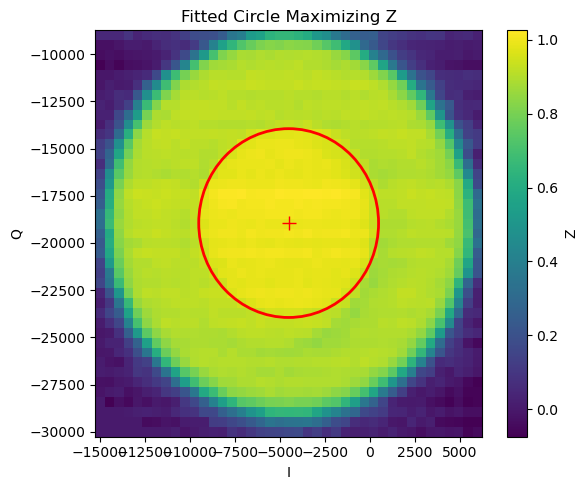

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# # === Load Data ===
# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")

X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params):
    x0, y0 = params
    r = 20000      # fixed radius
    k = 0.0005      # smoothness of the edge

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask (minimize this to maximize sum)
    return -np.sum(Z_vals * mask)

# === Initial Guess ===
initial_guess = [np.random.uniform(x[0], x[-1]), np.random.uniform(y[0], y[-1])]#[(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2]

# === Fit ===
result = minimize(objective, initial_guess, method='Nelder-Mead')  # Derivative-free method

# === Extract Results ===
x_opt, y_opt = result.x
print(f"Optimization success: {result.success}")
print(f"Fitted center: x = {x_opt:.2f}, y = {y_opt:.2f}")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 5000, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 3
    # data points      = 1681
    # variables        = 2
    chi-square         = 1.236e-141
    reduced chi-square = 7.363e-145
    Akaike info crit   = -557885.459
    Bayesian info crit = -557874.605
[[Variables]]
    x0: -180.000000 +/- 13.8832112 (7.71%) (init = -180)
    y0: -780.000000 +/- 0.48846815 (0.06%) (init = -780)


/var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_73074/321141030.py:44: RuntimeWarning: overflow encountered in exp
  mask = 1 / (1 + np.exp(k * (dist - r)))


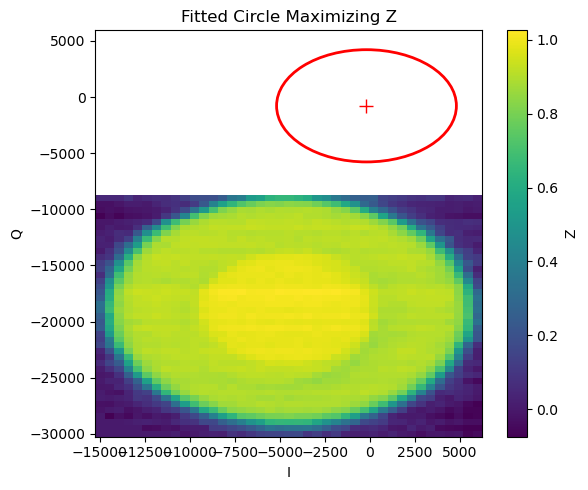

Fitted center: x = -180.00 ± 13.88, y = -780.00 ± 0.49


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  8 10:48:22 2025

@author: Tanvir
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from lmfit import minimize, Parameters, report_fit

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Interpolation function for smooth Z
Z = np.nan_to_num(Z, nan=0.0)
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === One Function for lmfit ===
def objective(params):
    x0 = params['x0']
    y0 = params['y0']
    r = 5000      # fixed radius
    k = 0.05     # smoothness of the edge

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative of Z under mask (we're minimizing, so this maximizes Z inside)
    return -Z_vals * mask

# === Initialize Parameters ===
params = Parameters()
params.add('x0', value=(x[0] + x[-1]) / 2)
params.add('y0', value=(y[0] + y[-1]) / 2)

# === Fit ===
result = minimize(objective, params, method='least_squares')
report_fit(result)

# === Extract Results ===
x_opt = result.params['x0'].value
y_opt = result.params['y0'].value
x_err = result.params['x0'].stderr
y_err = result.params['y0'].stderr

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 5000, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

# === Print Result ===
print(f"Fitted center: x = {x_opt:.2f} ± {x_err:.2f}, y = {y_opt:.2f} ± {y_err:.2f}")


In [1]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [lmfit]


Optimization success: True
Fitted center: x = -5106.50, y = -18071.88, radius = 7500.00


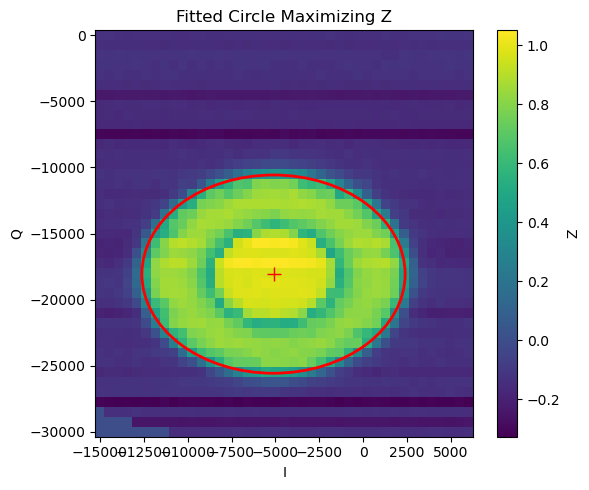

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

QA = np.loadtxt("130325_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params):
    x0, y0 = params
    r = 7500      # Fixed radius used in optimization
    k = 0.0005    # Smoothness of the edge (adjust for sharper transition if needed)

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask (minimize this to maximize sum)
    return -np.sum(Z_vals * mask)

# === Initial Guess ===
initial_guess = [(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2]  # Custom initial guess

# === Fit ===
result = minimize(objective, initial_guess, method='Nelder-Mead')  # Derivative-free method

# === Extract Results ===
x_opt, y_opt = result.x
r = 7500  # Use the same radius as in the objective function
print(f"Optimization success: {result.success}")
print(f"Fitted center: x = {x_opt:.2f}, y = {y_opt:.2f}, radius = {r:.2f}")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), r, color='red', fill=False, linewidth=2)  # Use r from objective
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

Optimization success: Multiple runs completed (500 successful)
Fitted center: x = -4495.76 ± 90.92, y = -19499.02 ± 82.24


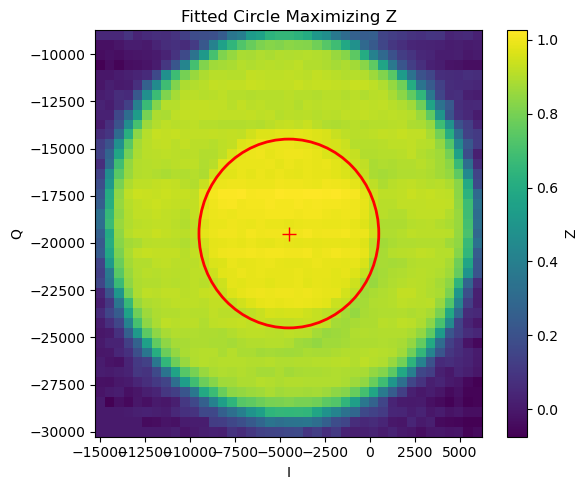

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params, z_vals):
    x0, y0 = params
    r = 20000      # fixed radius
    k = 0.005      # sharper smoothness of the edge (increased from 0.0005)

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask (minimize this to maximize sum)
    return -np.sum(z_vals * mask)

# === Initial Guesses (multiple starting points)
initial_guesses = [
    [(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2],  # Midpoint
    [-5000, -10000],                            # Near visual center
    [0, 0]                                      # Origin as fallback
]

# === Bootstrap for Uncertainty ===
n_boot = 500  # Increased iterations for stability
x_opts = []
y_opts = []

for _ in range(n_boot):
    # Resample Z_vals with replacement
    Z_boot = np.random.choice(Z_vals, size=Z_vals.shape, replace=True)
    
    # Try multiple initial guesses and take the best result
    best_value = float('inf')
    best_x, best_y = None, None
    for guess in initial_guesses:
        result = minimize(lambda params: objective(params, Z_boot), guess, method='Nelder-Mead')
        if result.success and result.fun < best_value:
            best_value = result.fun
            best_x, best_y = result.x
    
    if best_x is not None and best_y is not None:
        x_opts.append(best_x)
        y_opts.append(best_y)

# === Extract Results ===
if x_opts:
    x_opt = np.mean(x_opts)
    y_opt = np.mean(y_opts)
    x_err = np.std(x_opts)
    y_err = np.std(y_opts)
    print(f"Optimization success: Multiple runs completed ({len(x_opts)} successful)")
    print(f"Fitted center: x = {x_opt:.2f} ± {x_err:.2f}, y = {y_opt:.2f} ± {y_err:.2f}")
else:
    print("No successful optimizations in bootstrap runs")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 5000, color='red', fill=False, linewidth=2)  # Consistent radius
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

Optimization success: True
Fitted center: x = -4527.99, y = -16156.10
Estimated uncertainties: x = ±0.000000, y = ±0.000000


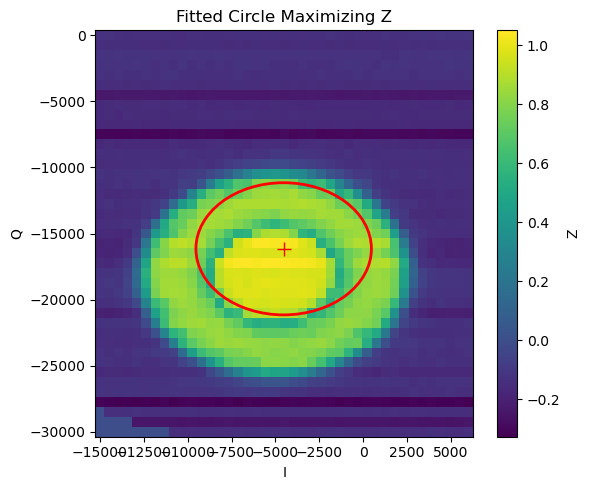

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

QA = np.loadtxt("130325_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params):
    x0, y0 = params
    r = 5000      # Reduced radius to focus on core region
    k = 0.01       # Sharper smoothness of the edge

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask (minimize this to maximize sum)
    return -np.sum(Z_vals * mask)

# === Initial Guess ===
initial_guess = [(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2]

# === Fit ===
result = minimize(objective, initial_guess, method='Nelder-Mead')
x_opt, y_opt = result.x
print(f"Optimization success: {result.success}")
print(f"Fitted center: x = {x_opt:.2f}, y = {y_opt:.2f}")

# === Numerical Hessian Approximation with Pseudo-Inverse ===
def compute_hessian(x0, y0, h=1e-4):  # Increased h for stability
    # Central difference approximation for Hessian
    f0 = objective([x0, y0])
    hessian = np.zeros((2, 2))
    
    # Partial derivatives
    for i in range(2):
        for j in range(2):
            x_plus = x0 if i == 0 else x0 + (h if j == 0 else 0)
            y_plus = y0 if i == 1 else y0 + (h if j == 1 else 0)
            x_minus = x0 if i == 0 else x0 - (h if j == 0 else 0)
            y_minus = y0 if i == 1 else y0 - (h if j == 1 else 0)
            f_plus = objective([x_plus, y_plus])
            f_minus = objective([x_minus, y_minus])
            hessian[i, j] = (f_plus - 2 * f0 + f_minus) / (h * h) if i == j else (f_plus + f_minus - 2 * f0) / (2 * h * h)

    # Use pseudo-inverse for singular matrices
    covariance = np.linalg.pinv(hessian)
    
    # Estimate residual variance (approximate from data spread)
    residual_var = np.var(Z_vals) / len(Z_vals)  # Rough estimate
    covariance *= residual_var
    return np.sqrt(np.diag(covariance))

# Compute errors
if result.success:
    x_err, y_err = compute_hessian(x_opt, y_opt)
    print(f"Estimated uncertainties: x = ±{x_err:.6f}, y = ±{y_err:.6f}")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 5000, color='red', fill=False, linewidth=2)  # Consistent radius
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

Optimization success: True
Fitted center: x = -4495.66, y = -19011.48
Hessian:
[[0.00000000e+00 2.27373675e-05]
 [4.54747351e-05 0.00000000e+00]]
Condition number: 2.0
Covariance:
[[    0.         21990.23255552]
 [43980.46511104     0.        ]]
Residual variance: 2.2737367544323206e-13
Estimated uncertainties: x = ±0.00, y = ±0.00


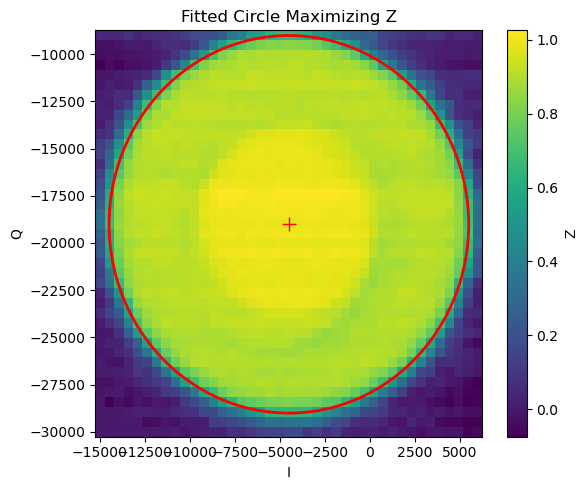

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params):
    x0, y0 = params
    r = 10000      # Reduced radius
    k = 0.01       # Sharper smoothness

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask
    return -np.sum(Z_vals * mask)

# === Initial Guess ===
initial_guess = [(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2]

# === Fit ===
result = minimize(objective, initial_guess, method='Nelder-Mead')
x_opt, y_opt = result.x
print(f"Optimization success: {result.success}")
print(f"Fitted center: x = {x_opt:.2f}, y = {y_opt:.2f}")

# === Numerical Hessian Approximation with Pseudo-Inverse ===
def compute_hessian(x0, y0, h=1e-4):
    # Central difference approximation for Hessian
    f0 = objective([x0, y0])
    hessian = np.zeros((2, 2))
    
    # Partial derivatives
    for i in range(2):
        for j in range(2):
            x_plus = x0 if i == 0 else x0 + (h if j == 0 else 0)
            y_plus = y0 if i == 1 else y0 + (h if j == 1 else 0)
            x_minus = x0 if i == 0 else x0 - (h if j == 0 else 0)
            y_minus = y0 if i == 1 else y0 - (h if j == 1 else 0)
            f_plus = objective([x_plus, y_plus])
            f_minus = objective([x_minus, y_minus])
            hessian[i, j] = (f_plus - 2 * f0 + f_minus) / (h * h) if i == j else (f_plus + f_minus - 2 * f0) / (2 * h * h)

    print(f"Hessian:\n{hessian}")
    print(f"Condition number: {np.linalg.cond(hessian)}")

    # Use pseudo-inverse for singular matrices
    covariance = np.linalg.pinv(hessian)
    print(f"Covariance:\n{covariance}")

    # Improved residual variance estimate (based on objective function spread)
    # Use the range of objective values near the optimum as a proxy
    f_perturb_x = objective([x0 + h, y0])
    f_perturb_y = objective([x0, y0 + h])
    residual_var = np.max([abs(f_perturb_x - f0), abs(f_perturb_y - f0)])  # Rough estimate
    print(f"Residual variance: {residual_var}")
    covariance *= residual_var
    return np.sqrt(np.diag(covariance))

# Compute errors
if result.success:
    x_err, y_err = compute_hessian(x_opt, y_opt)
    print(f"Estimated uncertainties: x = ±{x_err:.2f}, y = ±{y_err:.2f}")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 10000, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()

Optimization success: True
Fitted center: x = -4517.88, y = -16499.58
Hessian:
[[0.00000000e+00 3.70192765e-05]
 [6.05666628e-05 0.00000000e+00]]
Condition number: 1.6360844529750482
Regularized Covariance:
[[ -446.20267361 16518.10016411]
 [27025.00687119  -446.20267361]]
Residual variance: 6.17461637375527e-05
Uncertainty estimation failed: errors are zero or negative


/var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_73074/1509650585.py:89: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(covariance))


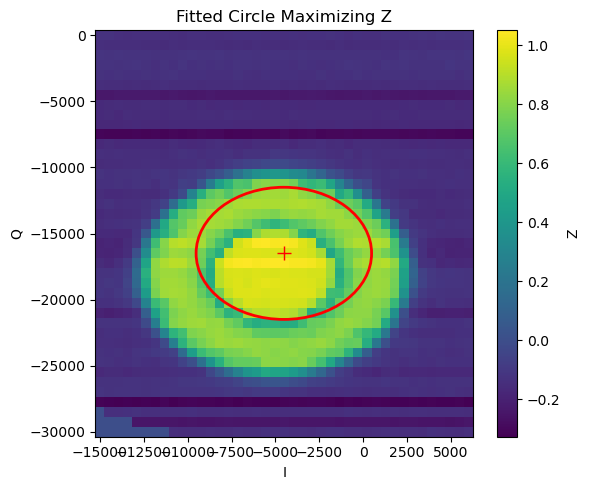

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

# === Load Data ===
QA = np.loadtxt("015317_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]

QA = np.loadtxt("130325_hist_sweep.txt")
X = QA[0:41, :]
Y = QA[41:82, :]
Z = QA[82:123, :]


x = X[0]
y = Y[:, 0]

# Handle NaNs in Z
Z = np.nan_to_num(Z, nan=0.0)

# Interpolation function for smooth Z
interp_Z = RegularGridInterpolator((y, x), Z, bounds_error=False, fill_value=0.0)

# Flattened coordinate grid
xx, yy = np.meshgrid(x, y)
flat_points = np.stack([yy.ravel(), xx.ravel()], axis=1)
Z_vals = interp_Z(flat_points)

# === Objective Function (scalar, negative sum for maximization) ===
def objective(params):
    x0, y0 = params
    r = 4000      # Reduced radius
    k = 0.02       # Even sharper smoothness

    # Distance from each point to the center
    dx = flat_points[:, 1] - x0
    dy = flat_points[:, 0] - y0
    dist = np.sqrt(dx**2 + dy**2)

    # Smooth circular mask (sigmoid edge)
    mask = 1 / (1 + np.exp(k * (dist - r)))

    # Negative sum of Z under mask
    return -np.sum(Z_vals * mask)

# === Initial Guess ===
initial_guess = [(x[0] + x[-1]) / 2, (y[0] + y[-1]) / 2]

# === Fit ===
result = minimize(objective, initial_guess, method='Nelder-Mead')
x_opt, y_opt = result.x
print(f"Optimization success: {result.success}")
print(f"Fitted center: x = {x_opt:.2f}, y = {y_opt:.2f}")

# === Numerical Hessian Approximation with Regularization and Pseudo-Inverse ===
def compute_hessian(x0, y0, h=1e-3, epsilon=1e-6):
    # Central difference approximation for Hessian
    f0 = objective([x0, y0])
    hessian = np.zeros((2, 2))
    
    # Partial derivatives
    for i in range(2):
        for j in range(2):
            x_plus = x0 if i == 0 else x0 + (h if j == 0 else 0)
            y_plus = y0 if i == 1 else y0 + (h if j == 1 else 0)
            x_minus = x0 if i == 0 else x0 - (h if j == 0 else 0)
            y_minus = y0 if i == 1 else y0 - (h if j == 1 else 0)
            f_plus = objective([x_plus, y_plus])
            f_minus = objective([x_minus, y_minus])
            hessian[i, j] = (f_plus - 2 * f0 + f_minus) / (h * h) if i == j else (f_plus + f_minus - 2 * f0) / (2 * h * h)

    print(f"Hessian:\n{hessian}")
    print(f"Condition number: {np.linalg.cond(hessian)}")

    # Regularize Hessian to ensure invertibility
    hessian_reg = hessian + epsilon * np.eye(2)
    covariance = np.linalg.pinv(hessian_reg)
    print(f"Regularized Covariance:\n{covariance}")

    # Residual variance estimate from objective perturbations
    f_perturb_x = objective([x0 + h, y0])
    f_perturb_y = objective([x0, y0 + h])
    residual_var = np.max([abs(f_perturb_x - f0), abs(f_perturb_y - f0)]) / h**2  # Scaled by h^2 for second derivative
    print(f"Residual variance: {residual_var}")
    covariance *= residual_var
    return np.sqrt(np.diag(covariance))

# Compute errors
if result.success:
    x_err, y_err = compute_hessian(x_opt, y_opt)
    if x_err > 0 and y_err > 0:
        print(f"Estimated uncertainties: x = ±{x_err:.2f}, y = ±{y_err:.2f}")
    else:
        print("Uncertainty estimation failed: errors are zero or negative")

# === Plot ===
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(label='Z')
circle = plt.Circle((x_opt, y_opt), 5000, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)
plt.plot(x_opt, y_opt, 'r+', markersize=10)
plt.title("Fitted Circle Maximizing Z")
plt.xlabel("I")
plt.ylabel("Q")
plt.tight_layout()
plt.show()